# Тестовое задание "МигКредит"

## Цель:
Построить модель логистической регрессии.

## Описание данных:

* Таблица buffer_table1

|столбец|описание|
|---|---|
|ucdb_id|уникальный id наблюдения|
|train|тип сэмпла, принимает 2 значения True и False. False – строки без разметки.|
|30+ 3MoB gt 0|целевое событие, 1 или 0, пустое там, где train – False|
|cash_hist|техническое поле, по которому нужно производить merge с остальными файлами|

* Таблица buffer_table2
|столбец|описание|
|---|---|
|Request_id|поле, к которому производится merge|
|Остальные поля – характеристики кредитной истории заемщика|

* Таблица buffer_table3

|столбец|описание|
|---|---|
|Request_id|поле, к которому производится merge.|
|Остальные поля|характеристики запросов кредитной истории заемщика.|

Baseline – > 45 gini на train и test’е

Прислать нужно csv файл с 2 столбцами, 1 – ucdb_id, 2 – predict_proba – столбец с вероятностями.


Request id это уникальный ид, по которому нужно делать merge, с исходником
create_tstamp это время создания записи
Можно считать что это дата расчета переменных
Остальные поля описывать нет смысла
Это поля - характеристики кредитной истории, что они значат не важно, важно как они влияют на целевое событие
А также таблицы 2 и 3 между собой нельзя соединить
45 джини это идеально
Можно и меньше, чтобы присылали решения с меньшими результатами)

----

# Решение
## 0. Библиотеки

In [97]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from collections import defaultdict
from sklearn.metrics import make_scorer, roc_auc_score
import pandas as pd
import numpy as np
from itertools import combinations
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from plot_metric.functions import BinaryClassification
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from collections import defaultdict
import string
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV, cross_val_score,\
                                    KFold, train_test_split, cross_validate, ParameterGrid,\
                                    cross_validate, cross_val_predict, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import confusion_matrix
# пайплайн
from sklearn.pipeline import Pipeline, make_union, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OneHotEncoder

# дамми-регрессор
from sklearn.dummy import DummyClassifier
from itertools import combinations
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve
import shutil

## 0. Функции

In [4]:
def convert_types(df):
    '''конвертирует типы (по возможности)'''
    df_c = df.copy()
    for col in df.columns:
        ser = df[col]
        try:
            ser2 = ser.astype('datetime64')
            df_c[col] = ser2
        except:
            try:
                ser_float =ser.astype(np.float32)
                ser_int =ser.astype(np.int32)
                if (ser_float == ser_int).all():
                    df_c[col] =ser_int
                else:
                    df_c[col] =ser_float
            except:
                try:
                    df_c[col] = ser.str.lower().str.strip()
                except:
                    df_c[col] = ser
    return df_c

## 1. Подготовка данных

In [5]:
df_buffer_table1 = pd.read_csv('buffer_table1.csv', sep=',').iloc[:, 1:].rename(columns ={'30+ 3MoB gt 0':'target'})
df_buffer_table2= pd.read_csv('buffer_table2.csv', sep=',', encoding = 'cp1251').iloc[:, 1:]\
                    .dropna(subset = ['REQUEST_ID'])
df_buffer_table3= pd.read_csv('buffer_table3.csv', encoding = 'cp1251').iloc[:, 1:]\
                    .dropna(subset = ['REQUEST_ID'])

In [6]:
# отделяем трейн от теста
mask_train = df_buffer_table1['train']
df_train = df_buffer_table1[mask_train].drop('train', 1)
df_test = df_buffer_table1[~mask_train].drop('train', 1)
# индексы трейна и теста
idx_train = df_train['cash_hist'].unique()
idx_test = df_test['cash_hist'].unique()

In [7]:
# испарвляем CREDITTOTALAMT
df_buffer_table2 = convert_types(df_buffer_table2)
df_buffer_table2['CREDITTOTALAMT'] = \
    df_buffer_table2['CREDITTOTALAMT'].astype(str)\
        .map(lambda x: re.sub('[^A-Za-z0-9]+', '', x))\
        .map(lambda x:''.join(l for l in x if l not in string.punctuation))\
        .replace('n', np.nan)\
        .astype(np.float32)

# таблица 1: трейн, тест
df_buffer_table2_tr = df_buffer_table2[df_buffer_table2['REQUEST_ID'].isin(idx_train)]
df_buffer_table2_te = df_buffer_table2[df_buffer_table2['REQUEST_ID'].isin(idx_test)]

### 1.1. df_buffer_table2_tr

In [8]:
dt_columns = df_buffer_table2_tr.select_dtypes(np.datetime64).columns.tolist()
obj_columns = df_buffer_table2_tr.select_dtypes(object).columns.tolist()
other_columns = df_buffer_table2_tr.drop(dt_columns+obj_columns, 1).columns.tolist()

In [9]:
df_buffer_table2_tr = (df_buffer_table2_tr.set_index('REQUEST_ID').join(df_train.set_index('cash_hist')[['target']]))\
    .reset_index()\
    .rename(columns={'index':'REQUEST_ID'})

In [10]:
# фильтруем значения
for col in tqdm_notebook(obj_columns):
    if col != 'UUID':
        ser_target1_tr = df_buffer_table2_tr[df_buffer_table2_tr['target']==1][col]
        ser_te = df_buffer_table2_te[col]
        to_use = list(set(ser_target1_tr.unique()).intersection(set(ser_te.unique())))
        df_buffer_table2_tr[col] = df_buffer_table2_tr[col].apply(lambda x: x if x in to_use else np.nan)
        df_buffer_table2_te[col] = df_buffer_table2_te[col].apply(lambda x: x if x in to_use else np.nan)

In [11]:
# 8 июля 2011 г.
# МигКредит получила свидетельство
# Центрального Банка РФ о включении
# компании в государственный реестр
# микрофинансовых организаций.
START_TS =pd.Timestamp('01-01-2011')

dt_tr = df_buffer_table2_tr[dt_columns]
dt_te = df_buffer_table2_te[dt_columns]

df_buffer_table2_tr = pd.concat([df_buffer_table2_tr.drop(dt_columns, 1), dt_tr.where(dt_tr>=START_TS)], 1)
df_buffer_table2_te = pd.concat([df_buffer_table2_te.drop(dt_columns, 1), dt_te.where(dt_te>=START_TS)], 1)

In [ ]:
df1_tr = df_buffer_table2_tr.drop(['target'], 1)
df1_te = df_buffer_table2_te

In [32]:
paymtPat_tr = df1_tr['paymtPat']
paymtPat_te = df1_te['paymtPat'].astype(str)

In [50]:
df1_tr['paymtPat'] = df1_tr['paymtPat'].astype(str)
df1_te['paymtPat'] = df1_te['paymtPat'].astype(str)
_paymtPat_tr = df1_tr.groupby('REQUEST_ID')['paymtPat'].apply(lambda x: ' '.join(x))
_paymtPat_te = df1_te.groupby('REQUEST_ID')['paymtPat'].apply(lambda x: ' '.join(x))

In [51]:
vec = TfidfVectorizer(max_features = 100)
vec.fit(_paymtPat_tr)

TfidfVectorizer(max_features=100)

In [53]:
tfidf_tr = vec.transform(_paymtPat_tr)
tfidf_te = vec.transform(_paymtPat_te)

### 1.2. df_buffer_table3_tr

In [18]:
# испарвляем CREDITTOTALAMT
df_buffer_table3 = convert_types(df_buffer_table3)

# таблица 2: трейн, тест
df_buffer_table3_tr = df_buffer_table3[df_buffer_table3['REQUEST_ID'].isin(idx_train)]
df_buffer_table3_te = df_buffer_table3[df_buffer_table3['REQUEST_ID'].isin(idx_test)]

## 2. Извлечение признаков

In [ ]:
def extract_features_v1(df1_tr, index_col ='REQUEST_ID'):
    
    L_str_bag=['currencyCode', 'inquiryPeriod', 'inqPurpose', 'inqPurposeText']
    
    L_numbers = ['creditLimit', 'curBalanceAmt', 'amtPastDue', 'termsAmt',
                 'amtOutstanding', 'CREDITTOTALAMT', 'PRINCIPALOUTSTANDING',
                 'PRINCIPALPASTDUE', 'OTHERAMTOUTSTANDING', 'OTHERAMTPASTDUE',
                 'INTOUTSTANDING', 'INTPASTDUE']
    L_dt = ['openedDt', 'lastPaymtDt', 'closedDt', 'reportingDt', 'paymtPatStartDt', 'lastUpdatedDt',
            'accountRatingDate', 'paymentDueDate', 'interestPaymentDueDate', 'DATE_RESPONSE',
            'CREATE_TSTAMP', 'ETL_TIMESTAMP', 'GRACEENDDT']
    
    idx_train = df1_tr[index_col].unique()
    df_features = pd.DataFrame(index= idx_train)
    for REQUEST_ID, subdf in tqdm_notebook(df1_tr.groupby('REQUEST_ID')):

        #  число записей
        df_features.loc[REQUEST_ID, 'nrows'] = subdf.shape[0]

        # делаем мешок категорий
        for col in L_str_bag:
            shares =subdf[col].value_counts(normalize= True)
            for key, value in shares.items():
                df_features.loc[REQUEST_ID, f'{col}.{key}'] = value

        # мешок numdays, monthsReviewed
        for col in L_numdays_bag:
            shares=subdf[col].value_counts(normalize = True)
            for k, v in shares.items():
                df_features.loc[REQUEST_ID,f'{shares.name}.{k}'] = v
        # числа
        for col in L_numbers:         
            _mean = (subdf[L_numbers]).mean()
            _sum = (subdf[L_numbers]).sum()
            _min =subdf[L_numbers][subdf[L_numbers]!=0].min()
            _max= subdf[L_numbers][subdf[L_numbers]!=0].max()
            _zeros = (subdf[L_numbers]!=0).mean()        

            prefixes =['mean', 'sum', 'min', 'max', 'zeros']
            L_ser = [_mean, _sum, _min, _max, _zeros]

            for pref, ser in zip(prefixes,L_ser):
                for k, v in ser.items():
                    df_features.loc[REQUEST_ID,f'{pref}.{k}'] = v     

        # жизненный цикл
        lifetime_ser = (subdf[L_dt].max() - subdf[L_dt].min())/ np.timedelta64(1, 'D')
        for k, v in lifetime_ser.items():
            df_features.loc[REQUEST_ID,f'{k}.lifetime'] = v 

        # промежутки между датами
        for col in L_dt:
            ser = subdf[col].sort_values()
            cs = (ser.dropna().drop_duplicates().diff() / np.timedelta64(1, 'D')) // 7
            df_features.loc[REQUEST_ID,f'{col}.diff0'] = (cs==0).mean()
            df_features.loc[REQUEST_ID,f'{col}.diff1'] = (cs==1).mean()
            df_features.loc[REQUEST_ID,f'{col}.diff2'] = (cs==2).mean()
            df_features.loc[REQUEST_ID,f'{col}.diff3'] = (cs==3).mean()
            df_features.loc[REQUEST_ID,f'{col}.diff4'] = (cs==4).mean()
            df_features.loc[REQUEST_ID,f'{col}.diff5+'] = (cs>=5).mean()
            
    return df_features

In [70]:
def extract_features_v2(df1_tr, index_col ='REQUEST_ID'):
    
    L_str_bag=['inquiryPeriod', 'inqPurpose', 'inqPurposeText']
    
    L_numbers = ['inqAmount']
    
    
    idx_train = df1_tr[index_col].unique()
    df_features = pd.DataFrame(index= idx_train)
    for REQUEST_ID, subdf in tqdm_notebook(df1_tr.groupby('REQUEST_ID')):

        #  число записей
        df_features.loc[REQUEST_ID, 'nrows'] = subdf.shape[0]

        # делаем мешок категорий
        for col in L_str_bag:
            shares =subdf[col].value_counts(normalize= True)
            for key, value in shares.items():
                df_features.loc[REQUEST_ID, f'{col}.{key}'] = value

        # числа
        for col in L_numbers:         
            _mean = (subdf[L_numbers]).mean()
            _sum = (subdf[L_numbers]).sum()
            _min =subdf[L_numbers][subdf[L_numbers]!=0].min()
            _max= subdf[L_numbers][subdf[L_numbers]!=0].max()
            _zeros = (subdf[L_numbers]!=0).mean()        

            prefixes =['mean', 'sum', 'min', 'max', 'zeros']
            L_ser = [_mean, _sum, _min, _max, _zeros]

            for pref, ser in zip(prefixes,L_ser):
                for k, v in ser.items():
                    df_features.loc[REQUEST_ID,f'{pref}.{k}'] = v          
            
    return df_features

In [98]:
# f1_tr = extract_features_v1(df1_tr, index_col ='REQUEST_ID')
# f1_te = extract_features_v1(df1_te, index_col ='REQUEST_ID')

In [99]:
# f1_tr.to_pickle('f1_tr.pickle')
# f1_te.to_pickle('f1_te.pickle')

In [100]:
# f1_tr = pd.concat([f1_tr, pd.DataFrame(tfidf_tr.toarray(), index = f1_tr.index).add_prefix('tfidf.')],1)

In [101]:
# f2_tr = extract_features_v2(df_buffer_table3_tr, index_col ='REQUEST_ID')
# f2_te = extract_features_v2(df_buffer_table3_te, index_col ='REQUEST_ID')

In [102]:
# f1_tr = f1_tr.reset_index().rename(columns = {'index':'cash_hist'})
# f1_te = f1_te.reset_index().rename(columns = {'index':'cash_hist'})
# f2_tr = f2_tr.reset_index().rename(columns = {'index':'cash_hist'})
# f2_te = f2_te.reset_index().rename(columns = {'index':'cash_hist'})

In [143]:
# X_tr = pd.concat([pd.merge(df_train.drop('target', 1), f1_tr, on ='cash_hist', how='left')\
#                       .set_index('ucdb_id').drop('cash_hist', 1),\
#                   pd.merge(df_train.drop('target', 1), f2_tr, on ='cash_hist', how='left')\
#                       .set_index('ucdb_id').drop('cash_hist', 1)], 1)
# y_tr = df_train.set_index('ucdb_id')['target']

In [144]:
# X_te = pd.concat([pd.merge(df_test.drop('target', 1), f1_te, on ='cash_hist', how='left')\
#                       .set_index('ucdb_id').drop('cash_hist', 1),\
#                   pd.merge(df_test.drop('target', 1), f2_te, on ='cash_hist', how='left')\
#                       .set_index('ucdb_id').drop('cash_hist', 1)], 1)
# y_te = df_test.set_index('ucdb_id')['target']

In [120]:
# cols_to_use = list(set(X_tr.columns).intersection(set(X_te.columns)))
# X_tr = X_tr[cols_to_use]
# X_te = X_te[cols_to_use]

In [127]:
# X_tr.to_pickle('X_tr.pickle')
# X_te.to_pickle('X_te.pickle')
# y_tr.to_pickle('y_tr.pickle')
# y_te.to_pickle('y_te.pickle')

## 3. Моделирование

In [145]:
SEED = 13
SKF = StratifiedKFold(5, random_state= SEED, shuffle = True)
logit = LogisticRegression(random_state = SEED)

In [146]:
_x_tr, _x_ho, _y_tr, _y_ho = train_test_split(X_tr, y_tr, test_size = .1, stratify = y_tr, shuffle = True, random_state = SEED)

In [147]:
ppl = make_pipeline(MinMaxScaler(), SimpleImputer(strategy ='constant', fill_value=-1))
ppl.fit(_x_tr)
_x_tr = ppl.transform(_x_tr)
_x_ho = ppl.transform(_x_ho)
_x_te = ppl.transform(X_te)

In [148]:
class SklearnHelperFeatureSelector(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, model, cv, scoring, show_progress):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.show_progress = show_progress
    def fit(self, X, y=None):
        #assert (isinstance(X, np.ndarray)) or (X.getformat() == 'csc')
        _X = X.copy()
        cv_scores = []
        for i in tqdm_notebook(range(_X.shape[1])):
            try:
                _X_curr = _X[:, i].toarray().reshape(-1,1)
            except:
                _X_curr = _X[:, i].reshape(-1,1)                
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()            
            cv_scores.append(mean_cv_score)
            
        order = np.argsort(cv_scores)[::-1]
        to_drop_before, best_features, best_cv_score = [], [order[0]], -np.inf
        for i in tqdm_notebook(order[1:]):
            curr_features = best_features+[i]
            _X_curr = _X[:, curr_features]
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            if mean_cv_score>best_cv_score:
                best_cv_score = mean_cv_score
                best_features = curr_features
                if self.show_progress:
                    print('new best score = {:.10f}'.format(best_cv_score))
            else:
                to_drop_before.append(i)
        while True:
            to_drop_after = []
            for i in tqdm_notebook(to_drop_before):
                curr_features = best_features+[i]
                _X_curr = _X[:, curr_features]
                mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
                if mean_cv_score>best_cv_score:
                    best_cv_score = mean_cv_score
                    best_features = curr_features
                    if self.show_progress:
                        print('new best score = {:.10f}'.format(best_cv_score))
                else:
                    to_drop_after.append(i)
            if to_drop_before == to_drop_after:
                break
            else:
                to_drop_before = to_drop_after  
        self.best_features_ = best_features
        self.best_score_ = best_cv_score
    def transform(self, _X):
        return _X[:, self.best_features_]

In [149]:
selector = SklearnHelperFeatureSelector(model=logit, cv=SKF, scoring='roc_auc', show_progress=True)

In [150]:
selector.fit(_x_tr, _y_tr)

new best score = 0.6165909350
new best score = 0.6741280501
new best score = 0.6857145958
new best score = 0.6859780010
new best score = 0.6923661291
new best score = 0.6925336629
new best score = 0.6930003413
new best score = 0.7133772901
new best score = 0.7204268943
new best score = 0.7205725618
new best score = 0.7224086810
new best score = 0.7251171519
new best score = 0.7271610690
new best score = 0.7294888106
new best score = 0.7298162066
new best score = 0.7303233329
new best score = 0.7303407891
new best score = 0.7310453315
new best score = 0.7311781826
new best score = 0.7314272324
new best score = 0.7317592451
new best score = 0.7329051314
new best score = 0.7329058434
new best score = 0.7331789185
new best score = 0.7333757374
new best score = 0.7334509140
new best score = 0.7340751807
new best score = 0.7341179255
new best score = 0.7347487383
new best score = 0.7350429905
new best score = 0.7350828413
new best score = 0.7352322068
new best score = 0.7354479749
new best s

new best score = 0.7724333264
new best score = 0.7725282561
new best score = 0.7726312478
new best score = 0.7730277568
new best score = 0.7734001715
new best score = 0.7735375934
new best score = 0.7737315871
new best score = 0.7738789774
new best score = 0.7740940335
new best score = 0.7740966749
new best score = 0.7741235023
new best score = 0.7742615673
new best score = 0.7744379440
new best score = 0.7744741657
new best score = 0.7745090092
new best score = 0.7746313177
new best score = 0.7749174390
new best score = 0.7750629687
new best score = 0.7751779961
new best score = 0.7754159290
new best score = 0.7755342408
new best score = 0.7755946945



new best score = 0.7756367732
new best score = 0.7758466383
new best score = 0.7758729605
new best score = 0.7760878099
new best score = 0.7761618840
new best score = 0.7761782377
new best score = 0.7762112208



new best score = 0.7762426879
new best score = 0.7762970549



In [ ]:
# with open('selector.pickle', 'wb') as f:
#     pickle.dump(selector, f)

In [151]:
_x_sel_tr = selector.transform(_x_tr)
_x_sel_ho = selector.transform(_x_ho)
_x_sel_te = selector.transform(_x_te)

In [190]:
def get_cv_ho_scores(_x_sel_tr,y_tr, _x_sel_ho, y_ho):
    logit.fit(_x_sel_tr, _y_tr)
    GINI_ho = 100*(2 * roc_auc_score(_y_ho, logit.predict_proba(_x_sel_ho)[:, 1])-1)
    GINI_cv = 100*(2 * cross_val_score(logit,_x_sel_tr, _y_tr,cv = SKF, scoring ='roc_auc').mean()-1)
    coefs_abs = pd.Series(dict(zip(X_tr.columns[selector.best_features_], logit.coef_.flatten()))).abs().reset_index()
    coefs_abs
    coefs_abs.columns = ['feature', 'coef_abs']    
    return (GINI_cv, GINI_ho, coefs_abs.sort_values('coef_abs', ascending = False))

In [240]:
_x_sel_tr = selector.transform(_x_tr)
_x_sel_ho = selector.transform(_x_ho)
_x_sel_te = selector.transform(_x_te)
GINI_cv, GINI_ho, coefs_abs = get_cv_ho_scores(_x_sel_tr,y_tr, _x_sel_ho, y_ho)

In [241]:
cvAB=pd.DataFrame()

In [242]:
cvAB.loc['f1', 'cv'] = GINI_cv
cvAB.loc['f1', 'ho'] = GINI_ho

In [243]:
cvAB

,cv,ho
f1,55.164899,40.653595


#### Переобучаемся на трейн?

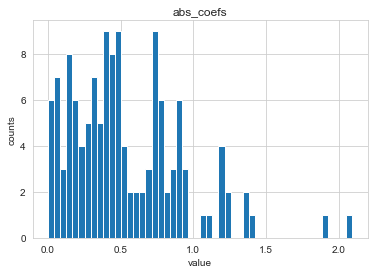

In [244]:
coefs_abs['coef_abs'].hist(bins = 50)
plt.title('abs_coefs')
plt.xlabel('value')
plt.ylabel('counts');

#### Выброшу последовательно топ 5 коэфов

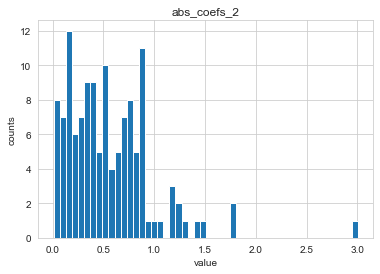

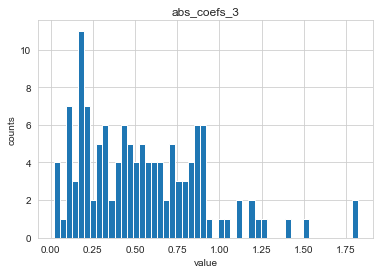

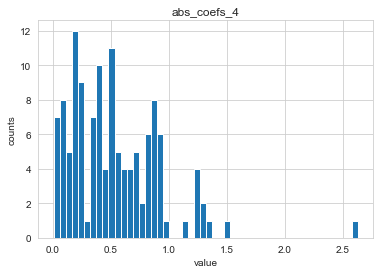

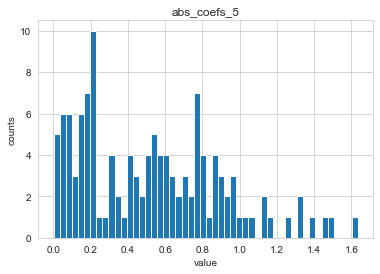

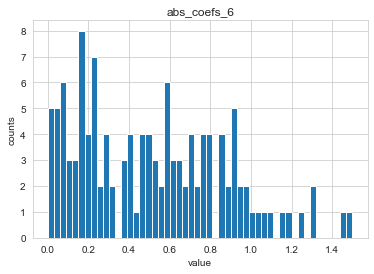

In [248]:
_x2_sel_tr_c = _x2_sel_tr.copy()
_x2_sel_ho_c = _x2_sel_ho.copy()
_x2_sel_te_c = _x2_sel_te.copy()
for i in [2, 3, 4, 5, 6]:
    idxmax = coefs_abs.index[0]
    _x2_sel_tr_c=np.delete(_x2_sel_tr_c,idxmax, axis = 1)
    _x2_sel_ho_c=np.delete(_x2_sel_ho_c,idxmax, axis = 1)
    _x2_sel_te_c=np.delete(_x2_sel_te_c,idxmax, axis = 1)
    GINI_cv, GINI_ho, coefs_abs = get_cv_ho_scores(_x2_sel_tr_c,y_tr, _x2_sel_ho_c, y_ho)
    cvAB.loc['f{}'.format(i), 'cv'] = GINI_cv
    cvAB.loc['f{}'.format(i), 'ho'] = GINI_ho
    
    
    coefs_abs['coef_abs'].hist(bins = 50)
    plt.title(f'abs_coefs_{i}')
    plt.xlabel('value')
    plt.ylabel('counts')
    plt.show()

In [249]:
cvAB

,cv,ho
f1,55.164899,40.653595
f2,53.671634,40.951344
f3,52.411134,38.598402
f4,51.576970,37.806826
f5,49.539434,36.005810
f6,49.107259,35.395788


#### Кажется,не переобучаюсь,просто данных маловато: распределение таргета на валидации и на отложенной сильно меняется

#### Сделаю n_iterations разбиений на валидационную и отложенную выборки,сравню метрики

In [290]:
n_iterations = 1000
sample_size=5
cvAB2 = pd.DataFrame()
df_predprob_te = pd.DataFrame(index= X_te.index,columns= list(range(n_iterations)))
for i in tqdm_notebook(range(n_iterations)):
    _x_tr, _x_ho, _y_tr, _y_ho = \
        train_test_split(X_tr, y_tr, test_size = .1, stratify = y_tr, shuffle = True, random_state = SEED+i)    
    
    ppl.fit(_x_tr)
    _x_tr = ppl.transform(_x_tr)
    _x_ho = ppl.transform(_x_ho)
    _x_te = ppl.transform(X_te)
    
    _x_sel_tr = selector.transform(_x_tr)
    _x_sel_ho = selector.transform(_x_ho)
    _x_sel_te = selector.transform(_x_te)
    
    GINI_cv, GINI_ho, coefs_abs = get_cv_ho_scores(_x_sel_tr,y_tr, _x_sel_ho, y_ho)
    cvAB2.loc['f{}'.format(i), 'cv'] = GINI_cv
    cvAB2.loc['f{}'.format(i), 'ho'] = GINI_ho
    
    X_TR = np.row_stack([_x_sel_tr, _x_sel_ho])
    Y_TR = pd.concat([_y_tr, _y_ho], 0).values    
    logit.fit(X_TR, Y_TR)
    y_predprob_te = logit.predict_proba(_x_sel_te)[:,1]
    df_predprob_te.loc[:,i] = y_predprob_te

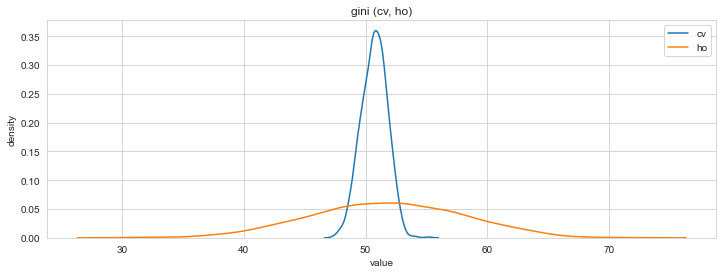

In [291]:
plt.figure(figsize = (12, 4))
sns.kdeplot(cvAB2['cv'])
sns.kdeplot(cvAB2['ho'])
plt.legend(['cv', 'ho'])
plt.xlabel('value')
plt.ylabel('density')
plt.title('gini (cv, ho)')
plt.show()

#### cравним  средние метрики на валидации и на отложенной  с помощью бутстрепа + теста стьюдента

In [292]:
cvbtAB = pd.DataFrame(np.r_[[cvAB2.sample(sample_size, random_state = i).mean().values \
                             for i in range(n_iterations)]], columns =['bootstrap_means_cv', 'bootstrap_means_ho'])
ALPHA = .05
if stats.ttest_ind(cvbtAB['bootstrap_means_cv'].values, cvbtAB['bootstrap_means_ho'].values)[1]<ALPHA:
    print('средние скоры на валидации и на отложенной одинаковые')
else:
    print('средние скоры на валидации и на отложенной разные')

средние скоры на валидации и на отложенной одинаковые


In [299]:
y_predprob_te = df_predprob_te.mean(1).to_frame('predprob')

In [301]:
y_predprob_te.to_excel('y_predprob_te.xlsx')